In [68]:
import numpy as np
import matplotlib.pyplot as plt
import client_moodle as server
%matplotlib inline

In [69]:
# constants
TEAM_ID = 'dGtgGZhUiTAytVHtKMwFEbEBZl9vcBwrsP5rOSTTrLQuOsDAY2'

GENE_MIN = -10
GENE_MAX = 10

CHROMOSOME_SIZE = 11
POPULATION_SIZE = 16 # Keep power of 2

GAUSS_NOISE_MEAN = 0.0
GAUSS_NOISE_STD = 0.1

MUTATE_PROB = 0.1

NUM_GENERATIONS = 20

In [70]:
INITIAL_WEIGHTS = [0.0, 0.1240317450077846, -6.211941063144333, 0.04933903144709126, 0.03810848157715883, 8.132366097133624e-05, -6.018769160916912e-05, -1.251585565299179e-07, 3.484096383229681e-08, 4.1614924993407104e-11, -6.732420176902565e-12]
len(INITIAL_WEIGHTS)

11

In [71]:
class Darwin:
    '''
    This class encapsulates a genetic algorithm runner over population consisting of weight vectors
    '''
    CHROMOSOME_SIZE = CHROMOSOME_SIZE
    POPULATION_SIZE = POPULATION_SIZE

    def __init__(self, val: list):
        if len(val) != self.CHROMOSOME_SIZE:
            raise ValueError

        self.population = self.generate_random_from_seed(val)
        self.avg_fitness = [] # maintained across generations
        self.max_fitness_across_generations = None
        self.best_chromosome_across_generations = None

    def generate_random_from_seed(self, val: list) -> np.ndarray:
        '''
        Generates a population from a single seed chromosome
        '''
        if len(val) != self.CHROMOSOME_SIZE:
            raise ValueError
        
        temp = [list(val) for i in range(self.POPULATION_SIZE)]
        temp = np.array(temp, dtype=np.double)

        noise = np.random.normal(
            loc=GAUSS_NOISE_MEAN,
            scale=GAUSS_NOISE_STD,
            size=(self.POPULATION_SIZE, self.CHROMOSOME_SIZE)
        )

        return np.clip(noise + temp, GENE_MIN, GENE_MAX)

    def get_fitness(self):

        def error_to_fitness(train_err, valid_err):
            return -valid_err

        fitness = []
        for chrom in self.population:
            train_err, valid_err = server.get_errors(TEAM_ID, list(chrom))
            fitness.append(error_to_fitness(train_err, valid_err))

        fitness = np.array(fitness, dtype=np.double)
        return fitness

    @classmethod
    def crossover(self, mom: np.ndarray, dad: np.ndarray):
        '''
        Generates offsprings out of the two parents
        '''

        def random_prefix(mom: np.ndarray, dad: np.ndarray):
            '''
            Random prefixes and suffixes
            '''
            thresh = np.random.randint(self.CHROMOSOME_SIZE) # index

            alice = np.copy(dad) # mom mom dad
            bob = np.copy(mom) # dad dad mom

            alice[0:thresh] = mom[0:thresh]
            bob[0:thresh] = dad[0:thresh]

            return alice, bob

        return random_prefix(mom, dad)

    @classmethod
    def mutate(self, population: np.ndarray):
        '''
        Mutates the population randomly
        '''
        
        def add_gauss_noise(population: np.ndarray):
            '''
            Adds a gaussian noise to some of the elements
            '''
            means = np.mean(population, axis=0) # mean of each gene across the population - to keep mutations of level
            
            # TODO: vectorise
            for idx, val in np.ndenumerate(population):
                if np.random.random() < MUTATE_PROB:
                    noise = np.random.normal(loc=means[idx[1]], scale=GAUSS_NOISE_STD)
                    population[idx] += noise

            return np.clip(population, GENE_MIN, GENE_MAX)

        return add_gauss_noise(population)


    def breed(self):
        '''
        Creates the next generation
        '''

        def russian_roulette():
            '''
            Whenever a parent is required, one is selected with probability proportional to fitness
            '''

            def get_parent_index(thresholds):
                draw = np.random.random() # in [0, 1)

                for i in range(len(thresholds)):
                    if draw < thresholds[i]:
                        return i
                return len(thresholds) - 1    
            
            fitness = self.get_fitness()
            normalized_fitness = (fitness - np.min(fitness)) / np.ptp(fitness) # in [0,1]
            
            self.avg_fitness.append(np.mean(fitness))
            self.update_best(fitness)

            thresholds = []
            thresh = 0.0
            fitness_sum = np.sum(normalized_fitness)
            for val in normalized_fitness:
                thresh = thresh + (val/fitness_sum)
                thresholds.append(thresh)

            offsprings = []
            for i in range(int(self.POPULATION_SIZE / 2)):
                mom = self.population[get_parent_index(thresholds)]
                dad = self.population[get_parent_index(thresholds)]

                alice, bob = self.crossover(mom, dad)
                offsprings.append(alice)
                offsprings.append(bob)
            return np.array(offsprings, dtype=np.double)
        

        offsprings = russian_roulette()
        self.population = self.mutate(offsprings)
    
    def update_best(self, fitness: np.ndarray):
        '''
        Updates the best chromosome across generations parameter from self.population
        '''
        best_idx = np.argmax(fitness)
        if (not self.max_fitness_across_generations) or fitness[best_idx] > self.max_fitness_across_generations:
            self.max_fitness_across_generations = fitness[best_idx]
            self.best_chromosome_across_generations = self.population[best_idx]

    def train(self):

        for i in range(NUM_GENERATIONS):
            self.breed()

        plt.plot(self.avg_fitness)
        plt.xlabel('Generations', fontsize=12)
        plt.ylabel('Average Fitness', fontsize=12)
        plt.title('Average Fitness across Generations', fontsize=14)
        plt.show()

        # haven't calculated the fitness of the final population
        fitness = self.get_fitness()
        self.update_best(fitness)
        
        return self.best_chromosome_across_generations, self.max_fitness_across_generations


In [72]:
class GenecticAlgorithm:
    '''
    This class encapsulates all the methods of a genectic algorithm
    '''
    def __init__(self):
        pass
    
    def calculate_fitness(self,weights):
        # returns a list of fitness score for each of the weight vector
        # The fitness will be calculated using the client_mooodle.py
        pass
    
    def crossover(self, parents, offspringSize):
        # generates new children from parents
        # there are various methods of doing it, blend, one-point,two-point, uniform. we need to try these.
        # also keep some of the original parents in the vector so that the new generation performs at least as good the previous one.
        pass
    
    def mutation(self, weights):
        # introduces mutation in the weights
        # randomly change the number by addind some random noise to maybe two-three weights in the weight vector.
        # but the noise has to be scaled to the level of weight to which we are adding it.
        pass
    
    def mating_pool(self, weights, fitness, numberOfParents):
        # selects the best parents for reproducing new generations
        # get the best parents by using the fitness scores, this method will not produce new offspring
        pass
    

In [73]:
darwin = Darwin(INITIAL_WEIGHTS)

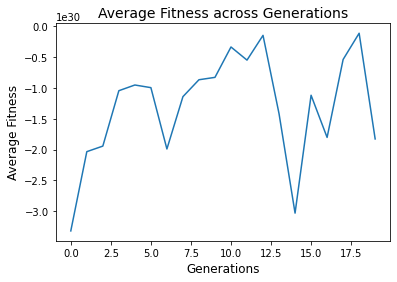

In [74]:
best_chromosome, final_fitness = darwin.train()

In [75]:
final_fitness

-7.668816116267021e+27

In [80]:
best_chromosome

array([ 3.26087355e-01,  3.28325147e-01, -1.00000000e+01,  6.70397819e-01,
       -3.99468844e-01,  6.23847751e-02, -3.78318545e-01, -2.28490414e-01,
       -3.32618915e-01,  1.41652489e-01,  9.23586106e-04])

In [81]:
input()
# to prevent submissions on running all cells

KeyboardInterrupt: Interrupted by user

In [77]:
status = server.submit(TEAM_ID, list(best_chromosome))
status

'successfully submitted'